# Preprocessing: Treatment of categorical *features*

## Previous steps

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv")
train_set, test_set = train_test_split(housing, test_size=0.2,
    stratify=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]),
    random_state=42
    )

X_train = train_set.drop("median_house_value", axis=1) # Remove the dependent variable column
y_train = train_set["median_house_value"].copy() # Save the dependent variable (labels)

We've left aside the 'ocean_proximity' column because it's a categorical variable. Most *Machine Learning* algorithms prefer to work with numbers, so it's better to convert these text categories to numbers. This is called **encoding**.

## OrdinalEncoder

In [32]:
from sklearn.preprocessing import OrdinalEncoder
cat_encoder = OrdinalEncoder()
housing_cat_ordinal_encoded = cat_encoder.fit_transform(X_train[["ocean_proximity"]])
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [33]:
housing_cat_ordinal_encoded[:8]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.]])

`OrdinalEncoder` encodes categories as numbers **with an order**. This will make *Machine Learning* algorithms assume that two close values are more similar than two distant values. For example, if we assign to 'NEAR BAY' the value 1, and to 'INLAND' the value 4, the algorithms would assume that 'NEAR BAY' is more similar to 'NEAR OCEAN' (value 2) than to 'INLAND', which is not true.

If we know that the categories have an order, we can use an **ordinal** encoding (for example, for ordered categories like "bad", "average", "good" and "excellent"). In this case, proximity to the coast seems to have an order. We could do a graphical check by representing the categories on a California map, and see if there's any relationship between the category and proximity to the coast.
<!-- TODO: difference with LabelEncoder -->

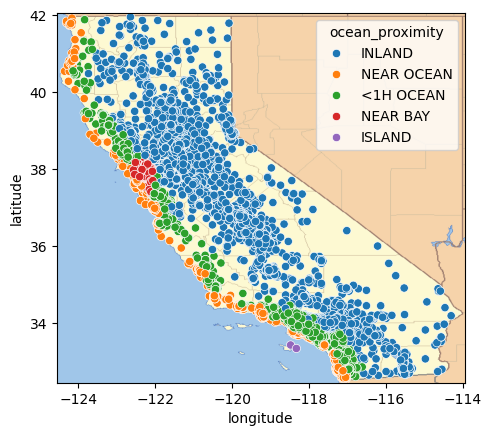

In [34]:
import seaborn as sns
import PIL
import matplotlib.pyplot as plt

sns.scatterplot(x="longitude", y="latitude", hue="ocean_proximity", data=X_train)
axis = -124.55, -113.95, 32.45, 42.05 # límites de longitud y latitud de la imagen
plt.imshow(PIL.Image.open("./img/california.png", mode='r'), extent=axis)
plt.show()

While there's some relationship between the category and proximity to the coast, it's not clear how the `INLAND` and `NEAR BAY` categories relate to the rest. Therefore, it's better to use a **non-ordinal** encoding.

## One-Hot Encoding


Another common solution when we're not clear about the order of categories is to create a binary attribute per category (convert that column into as many columns as values): an attribute equal to 1 when the category is "<1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the category is "INLAND" (and 0 otherwise), and so on. This is called ***one-hot encoding***, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called **dummy** attributes. scikit-learn provides the `OneHotEncoder` class to convert categorical values into *one-hot* vectors.

In [35]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(X_train[["ocean_proximity"]])
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

This method returns a ***sparse array*** from **SciPy**, which is a structure that compresses NumPy arrays to save memory when most of its positions contain zeros, storing only non-zero values with their positions. If we want to convert it to a NumPy array, we can use the `toarray()` method.

In [36]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

We can also use the `sparse_output=False` argument in the `OneHotEncoder` constructor.

In [37]:
OneHotEncoder(sparse_output=False).fit_transform(X_train[["ocean_proximity"]])

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

On the other hand, the `get_dummies()` function from pandas does the same thing (but returning a Pandas DataFrame).

In [38]:
pd.get_dummies(X_train["ocean_proximity"]).head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,False,True,False,False,False
15502,False,False,False,False,True
2908,False,True,False,False,False
14053,False,False,False,False,True
20496,True,False,False,False,False


However, OneHotEncoder, being able to separate the training process (with `fit()`) and the transformation process (with `transform()`), remembers the categories it was trained with.

This doesn't happen with `get_dummies()`: if used on a test dataset where a category that appeared in the training set doesn't appear, it won't create the corresponding column, and the test and training datasets will have a different number of columns.

In [39]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test) # always maps the existing categories at the time it's called

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [40]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

We can see how OneHotEncoder maintains the categories it was trained with, even if there are categories without any records.

Furthermore, if a category that it hasn't seen before appears in the test set, it will throw an exception. This is useful for detecting problems in the test set, but if we want it to simply ignore unknown categories, we can use the `handle_unknown='ignore'` argument in the `OneHotEncoder` constructor.

In [41]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [42]:
# cat_encoder.handle_unknown = "ignore" # this way we avoid the exception and simply returns zeros
try:
    cat_encoder.transform(df_test_unknown).toarray()
except Exception as e:
    print("EXCEPTION:", str(e))

EXCEPTION: Found unknown categories ['<2H OCEAN'] in column 0 during transform


The information about how a transformer was trained is stored in its attributes. With the `get_feature_names_out()` method we can obtain the names of the output columns.

In [43]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [44]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [45]:
cat_encoder.handle_unknown = "ignore"
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


It should be taken into consideration that, if a categorical attribute has many categories, the number of columns can grow a lot, which can slow down training and make the model more difficult to train. Additionally, if a category has very few examples, it may not be useful.